In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import asyncio
import nest_asyncio
import matplotlib.animation
from matplotlib.animation import PillowWriter

In [2]:
mu=132.712438e18
t0=0
R_earth=1.49870e11
R_mars=1.49870e11 * 1.524
V_earth=np.sqrt(mu/R_earth)
V_mars=np.sqrt(mu/R_mars)
T_earth=2*np.pi*R_earth/np.sqrt(mu/R_earth)
T_mars=2*np.pi*R_mars/np.sqrt(mu/R_mars)
w_earth=2*np.pi/T_earth
w_mars=2*np.pi/T_mars

In [3]:
x_earth=R_earth
y_earth=0
x_mars,y_mars=[],[]
for tt in range(0,int(T_mars/2),86400*10):
    x_mars.append(R_mars*np.cos(w_mars*(tt)))
    y_mars.append(R_mars*np.sin(w_mars*(tt)))

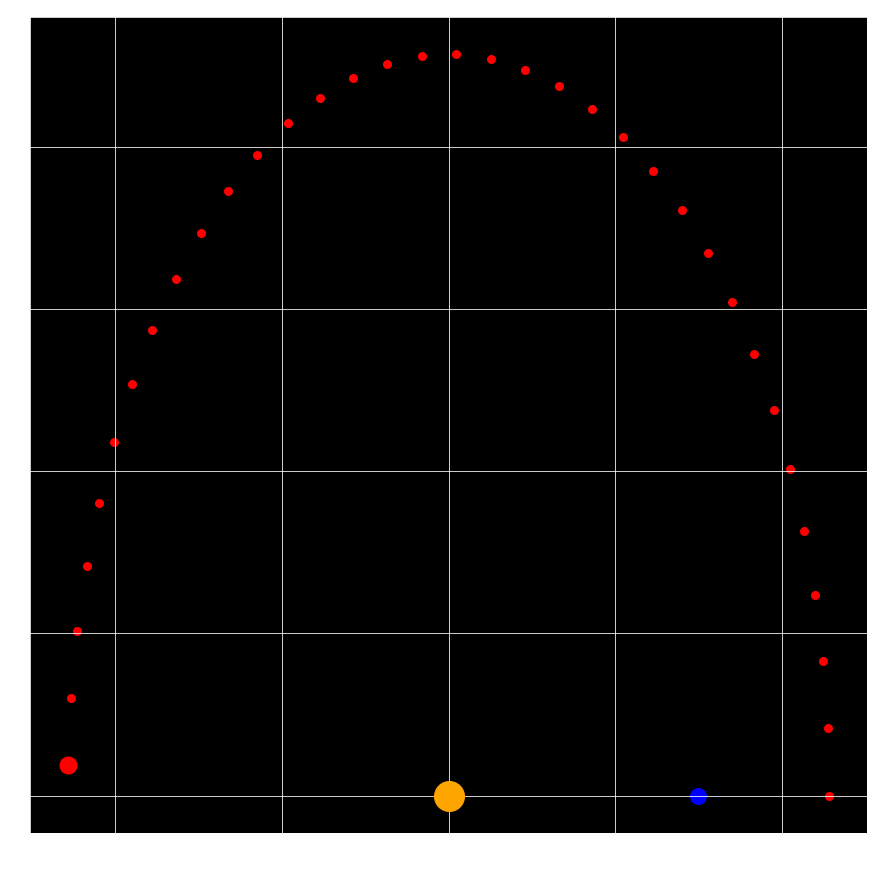

In [4]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(15, 15))
plt.grid()
plt.plot(0,0,marker="o", markersize=30,c='orange')
plt.scatter(x_earth,y_earth,marker="o", c='blue',linewidth=3.0)
plt.scatter(x_earth,y_earth,marker="o", c='blue',linewidth=11.0)
plt.scatter(x_mars,y_mars,marker="o", c='red',linewidth=3.0)
plt.scatter(x_mars[-1],y_mars[-1],marker="o", c='red',linewidth=12.0)
plt.show()

In [5]:
def f(init_values,t):
    x,vx,y,vy=init_values
    dxdt = vx
    dvxdt = (-mu*x)/(np.linalg.norm([x,y])**3)
    dydt = vy
    dvydt = (-mu*y)/(np.linalg.norm([x,y])**3)
    return [dxdt,dvxdt,dydt,dvydt]

In [6]:
def angle_between(v1, v2):
    v1_u = v1/np.linalg.norm(v1)
    v2_u = v2/np.linalg.norm(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
theta=[]
for m in range(0,len(x_mars)):
    theta.append(angle_between([x_mars[m],y_mars[m]],[R_earth,0]))

In [7]:
nest_asyncio.apply()
def lambertasd(varr, theta):
    deltal = 0.1
    varrtrue = [0, 0]
    tl = np.linspace(0, (200 * 86400))
    
    async def calculate_delta(var):
        nonlocal deltal, varrtrue
        
        ivl = [R_earth, var[0], 0, V_earth+var[1]]
        with np.errstate(all='ignore'):
            soll = odeint(f, ivl, tl, mxstep=5000)
            deltax = np.sqrt(R_mars * np.cos(theta) - soll[-1, 0]) * (1 / R_mars)
            deltay = np.sqrt(R_mars * np.sin(theta) - soll[-1, 2]) * (1 / R_mars)
            delta = np.sqrt((deltax ** 2) + (deltay ** 2))
        
        if delta < deltal:
            deltal = delta
            varrtrue = var
    
    async def run_calculations(varr):
        tasks = []
        for var in varr:
            task = asyncio.create_task(calculate_delta(var))
            tasks.append(task)
        await asyncio.gather(*tasks)
    
    asyncio.run(run_calculations(varr))
    
    return [varrtrue, deltal]

In [8]:
X,Y = np.mgrid[-7000:22000:1000, -11000:5000:1000]
xy = np.vstack((X.flatten(), Y.flatten())).T
traj=[]
for q in theta:
    traj.append(lambertasd(xy,q))

In [9]:
mintraj=[]
for qq in range(0,len(traj)):
    mintraj.append(abs(traj[qq][0][0])+abs(traj[qq][0][1]))
np.argmin(mintraj)

28

In [10]:
trajc=[]
X2,Y2 = np.mgrid[traj[np.argmin(mintraj)][0][0]+400:traj[np.argmin(mintraj)][0][0]+600:0.1, traj[np.argmin(mintraj)][0][1]+180:traj[np.argmin(mintraj)][0][1]+220:5]
xy2 = np.vstack((X2.flatten(), Y2.flatten())).T
trajc.append(lambertasd(xy2,theta[np.argmin(mintraj)]))
trajc

[[array([ 549.9, 3180. ]), 1.3535448807631595e-07]]

In [11]:
tl=np.linspace(0,(200*86400))
solll=[]
ivll=[R_earth,trajc[0][0][0],0,V_earth+trajc[0][0][1]]
solll=odeint(f,ivll,tl)

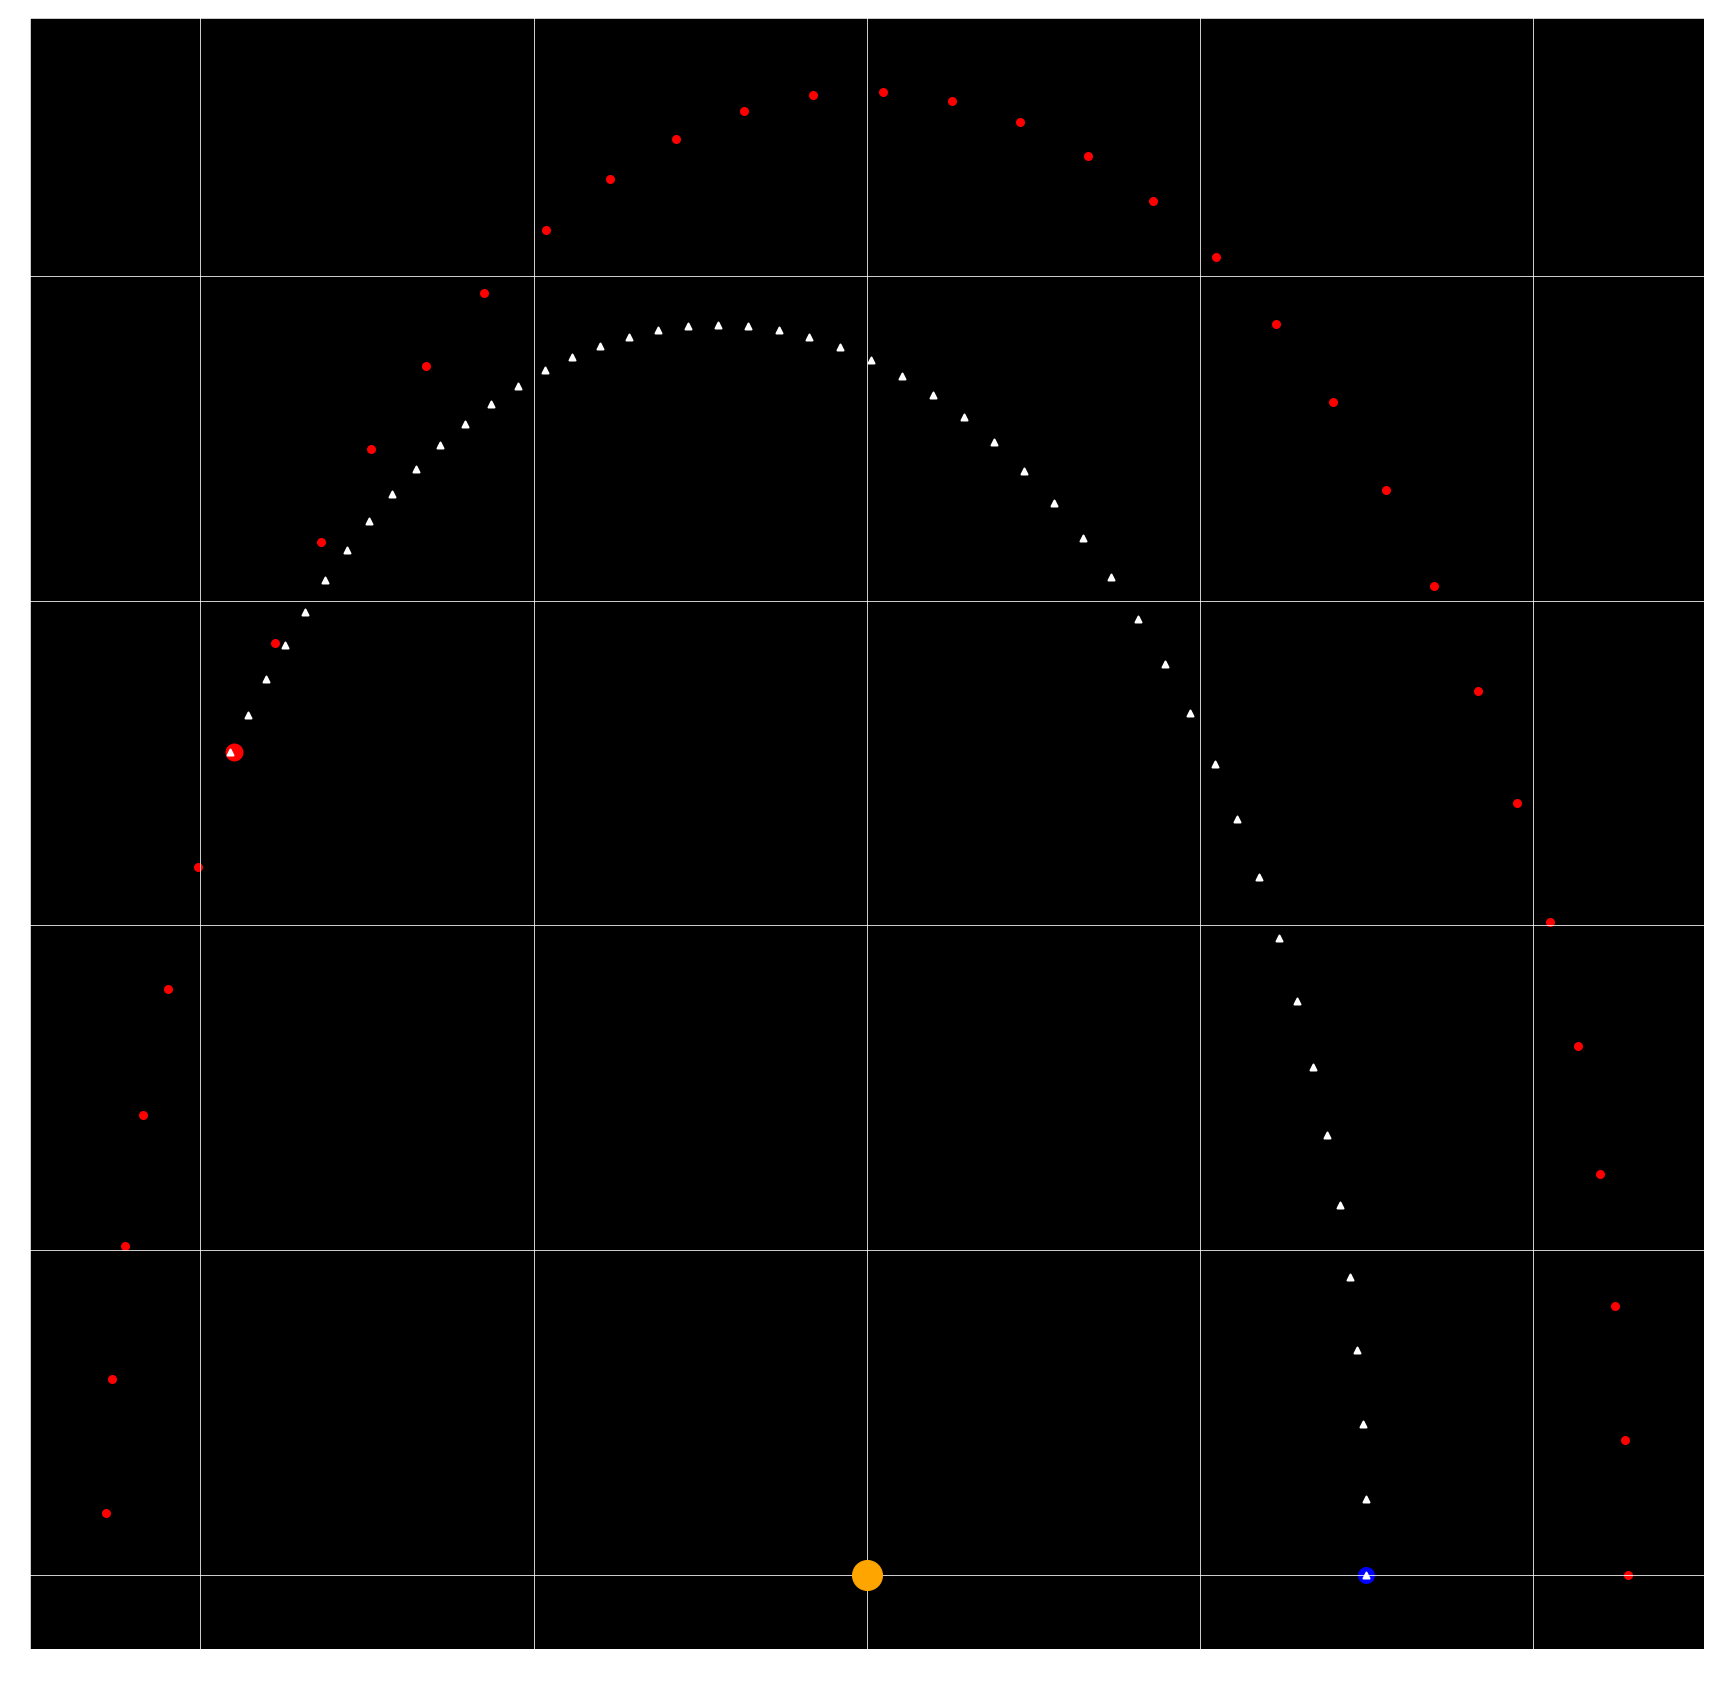

In [12]:
fig = plt.figure(figsize=(30, 30))
plt.grid()
plt.plot(0,0,marker="o", markersize=30,c='orange')
plt.scatter(x_earth,y_earth,marker="o", c='blue',linewidth=3.0)
plt.scatter(x_earth,y_earth,marker="o", c='blue',linewidth=11.0)
plt.scatter(x_mars,y_mars,marker="o",linewidth=3.0, c='red')
plt.scatter(x_mars[np.argmin(mintraj)],y_mars[np.argmin(mintraj)],marker="o",linewidth=12.0, c='red')
plt.scatter(solll[:,0],solll[:,2],c="w",marker="^",linewidth=2.0)
plt.show()

In [13]:
'''x_earth,y_earth=[],[]
x_mars,y_mars=[],[]
for tt in range(0,int(T_mars/2),int(86400*6.9)):
    x_mars.append(R_mars*np.cos(w_mars*(tt)))
    y_mars.append(R_mars*np.sin(w_mars*(tt)))
for ttt in range(0,int(T_earth),int(86400*7.4)):
    x_earth.append(R_earth*np.cos(w_earth*(ttt)))
    y_earth.append(R_earth*np.sin(w_earth*(ttt)))
    
fig = plt.figure(figsize=(30, 30))
plt.grid()
plt.xlim([-R_mars*1.1, R_mars*1.1])
plt.ylim([-R_mars*1.1, R_mars*1.1])
def animate(i):
    plt.plot(0,0,marker="o", markersize=30,c='orange')
    plt.scatter(x_earth[i],y_earth[i],marker="o", c='blue',linewidth=5.0)
    plt.scatter(x_mars[i],y_mars[i],marker="o", c='red',linewidth=5.0)
    plt.scatter(solll[i,0],solll[i,2],c="w",marker="^",linewidth=4.0)
anim = matplotlib.animation.FuncAnimation(fig, animate)
anim.save("lambert.gif",writer=PillowWriter())'''

'x_earth,y_earth=[],[]\nx_mars,y_mars=[],[]\nfor tt in range(0,int(T_mars/2),int(86400*6.9)):\n    x_mars.append(R_mars*np.cos(w_mars*(tt)))\n    y_mars.append(R_mars*np.sin(w_mars*(tt)))\nfor ttt in range(0,int(T_earth),int(86400*7.4)):\n    x_earth.append(R_earth*np.cos(w_earth*(ttt)))\n    y_earth.append(R_earth*np.sin(w_earth*(ttt)))\n    \nfig = plt.figure(figsize=(30, 30))\nplt.grid()\nplt.xlim([-R_mars*1.1, R_mars*1.1])\nplt.ylim([-R_mars*1.1, R_mars*1.1])\ndef animate(i):\n    plt.plot(0,0,marker="o", markersize=30,c=\'orange\')\n    plt.scatter(x_earth[i],y_earth[i],marker="o", c=\'blue\',linewidth=5.0)\n    plt.scatter(x_mars[i],y_mars[i],marker="o", c=\'red\',linewidth=5.0)\n    plt.scatter(solll[i,0],solll[i,2],c="w",marker="^",linewidth=4.0)\nanim = matplotlib.animation.FuncAnimation(fig, animate)\nanim.save("lambert.gif",writer=PillowWriter())'